<a href="https://colab.research.google.com/github/AvantiShri/OceanHackathon2021_MappingBlueCarbon/blob/master/av_code/VisualizeFeatureEmbeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Download Adrienne's original 200mb dataset
!gdown https://drive.google.com/uc?id=1E9OG54FzS7DiF1Mmn8bI7QVD4ihGyCQ9

Downloading...
From: https://drive.google.com/uc?id=1E9OG54FzS7DiF1Mmn8bI7QVD4ihGyCQ9
To: /content/BlueCarbonImages.zip
100% 203M/203M [00:01<00:00, 173MB/s]


In [2]:
!unzip BlueCarbonImages.zip

Archive:  BlueCarbonImages.zip
   creating: BlueCarbonImages/
   creating: BlueCarbonImages/valid/
  inflating: BlueCarbonImages/.DS_Store  
  inflating: __MACOSX/BlueCarbonImages/._.DS_Store  
   creating: BlueCarbonImages/test/
   creating: BlueCarbonImages/train/
  inflating: BlueCarbonImages/valid/.DS_Store  
  inflating: __MACOSX/BlueCarbonImages/valid/._.DS_Store  
   creating: BlueCarbonImages/valid/Mangrove/
   creating: BlueCarbonImages/valid/SaltMarsh/
   creating: BlueCarbonImages/valid/Seagrass/
  inflating: BlueCarbonImages/test/.DS_Store  
  inflating: __MACOSX/BlueCarbonImages/test/._.DS_Store  
   creating: BlueCarbonImages/test/Mangrove/
   creating: BlueCarbonImages/test/SaltMarsh/
   creating: BlueCarbonImages/test/Seagrass/
  inflating: BlueCarbonImages/train/.DS_Store  
  inflating: __MACOSX/BlueCarbonImages/train/._.DS_Store  
   creating: BlueCarbonImages/train/Mangrove/
   creating: BlueCarbonImages/train/SaltMarsh/
   creating: BlueCarbonImages/train/Seagrass/


To use tensorflow's directory data loaders, we need to symlink only the relevant images (and none of the "cloud" subdirectories) into directories of their own

In [3]:
!mkdir /content/BlueCarbonLoadDir
%cd /content/BlueCarbonLoadDir
!mkdir train valid test

%cd /content/BlueCarbonLoadDir/train
!mkdir Mangrove Seagrass SaltMarsh
!ln -s /content/BlueCarbonImages/train/Mangrove/* Mangrove/
!ln -s /content/BlueCarbonImages/train/Seagrass/* Seagrass/
!ln -s /content/BlueCarbonImages/train/Mangrove/* SaltMarsh/

%cd /content/BlueCarbonLoadDir/valid
!mkdir Mangrove Seagrass SaltMarsh
!ln -s /content/BlueCarbonImages/valid/Mangrove/* Mangrove/
!ln -s /content/BlueCarbonImages/valid/Seagrass/* Seagrass/
!ln -s /content/BlueCarbonImages/valid/Mangrove/* SaltMarsh/

%cd /content/BlueCarbonLoadDir/test
!mkdir Mangrove Seagrass SaltMarsh
!ln -s /content/BlueCarbonImages/test/Mangrove/* Mangrove/
!ln -s /content/BlueCarbonImages/test/Seagrass/* Seagrass/
!ln -s /content/BlueCarbonImages/test/Mangrove/* SaltMarsh/

%cd /content

/content/BlueCarbonLoadDir
/content/BlueCarbonLoadDir/train
/content/BlueCarbonLoadDir/valid
/content/BlueCarbonLoadDir/test
/content


In [5]:
#Count the numbers of each type
!ls BlueCarbonLoadDir/train/Mangrove/*.png | wc -l
!ls BlueCarbonLoadDir/train/Seagrass/*.png | wc -l
!ls BlueCarbonLoadDir/train/SaltMarsh/*.png | wc -l

145
283
145


In [13]:
#Also get the number of unique distinct regions
import glob

def count_distinct_locs(dir):
  print(dir)
  image_names = [x.split("/")[-1] for x in glob.glob(dir+"*.png")]
  unique_locs = set(["_".join(x.split("_")[:2]) for x in image_names])
  print("Total images:",len(image_names))
  print("Numbed of unique locations:",len(unique_locs))

count_distinct_locs("BlueCarbonLoadDir/train/Mangrove/")
count_distinct_locs("BlueCarbonLoadDir/train/Seagrass/")
count_distinct_locs("BlueCarbonLoadDir/train/SaltMarsh/")

BlueCarbonLoadDir/train/Mangrove/
Total images: 145
Numbed of unique locations: 34
BlueCarbonLoadDir/train/Seagrass/
Total images: 283
Numbed of unique locations: 93
BlueCarbonLoadDir/train/SaltMarsh/
Total images: 145
Numbed of unique locations: 34


In [32]:
#This dataset seems small enough that it can be read into memory.
# Collate the images by their location

from collections import defaultdict

def collate_images_by_loc(dir):
    image_names = [x.split("/")[-1] for x in glob.glob(dir+"/*.png")]
    unique_loc_to_image_names = defaultdict(list)
    unique_loc_to_nparr = defaultdict(list)
    for image_name in image_names:
        loc = "_".join(image_name.split("_")[:2])
        unique_loc_to_image_names[loc].append(image_name)
        unique_loc_to_nparr[loc].append(plt.imread(dir+"/"+image_name))
    for unique_loc in unique_loc_to_nparr:
        unique_loc_to_nparr[unique_loc] =\
          np.array(unique_loc_to_nparr[unique_loc])
    return unique_loc_to_image_names, unique_loc_to_nparr

_, train_mg_loctoarrs = collate_images_by_loc("BlueCarbonLoadDir/train/Mangrove/")
_, train_sm_loctoarrs = collate_images_by_loc("BlueCarbonLoadDir/train/SaltMarsh/")
_, train_sg_loctoarrs = collate_images_by_loc("BlueCarbonLoadDir/train/Seagrass/")

_, valid_mg_loctoarrs = collate_images_by_loc("BlueCarbonLoadDir/valid/Mangrove/")
_, valid_sm_loctoarrs = collate_images_by_loc("BlueCarbonLoadDir/valid/SaltMarsh/")
_, valid_sg_loctoarrs = collate_images_by_loc("BlueCarbonLoadDir/valid/Seagrass/")

In [23]:
#Pull the model

import tensorflow.compat.v1 as tf #needed for the bigearthnet module it seems
tf.disable_eager_execution()
tf.disable_v2_behavior()
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tf.keras.backend.clear_session()
bigearth_module = hub.Module(
    "https://tfhub.dev/google/remote_sensing/bigearthnet-resnet50/1",
    #trainable=True, tags={"train"}
    )
#Documentation from the page:
#For this module, the size of the input image is flexible, but it would be best
# to match the model training input, which was height x width = 224 x 224
# pixels. The input images are expected to have color values in the range [0,1]

bigearth_embedding_model = tf.keras.models.Sequential(
    layers=[
        hub.KerasLayer(bigearth_module, input_shape=(224, 224, 3),
                       #trainable=True,
                       arguments={"as_dict": True},
                       #output_key="default"
                       #output_key="block4"
                       output_key="block4"
                       ),
        #tf.keras.layers.Cropping2D(cropping=(3,3)), #take the very center of the 7x7
        tf.keras.layers.GlobalAveragePooling2D()
])


Instructions for updating:
non-resource variables are not supported in the long term
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [33]:
def avgpred_on_loctoarrs(model, loctoarrs):
    return np.array([
        np.mean(model.predict(loctoarrs[loc]), axis=0)
        for loc in loctoarrs])

#Get the bigearth embeddings

bigearth_embedding_train_mg = avgpred_on_loctoarrs(
    model=bigearth_embedding_model,
    loctoarrs=train_mg_loctoarrs)
bigearth_embedding_train_sm = avgpred_on_loctoarrs(
    model=bigearth_embedding_model,
    loctoarrs=train_sm_loctoarrs)
bigearth_embedding_train_sg = avgpred_on_loctoarrs(
    model=bigearth_embedding_model,
    loctoarrs=train_sg_loctoarrs)

bigearth_embedding_valid_mg = avgpred_on_loctoarrs(
    model=bigearth_embedding_model,
    loctoarrs=valid_mg_loctoarrs)
bigearth_embedding_valid_sm = avgpred_on_loctoarrs(
    model=bigearth_embedding_model,
    loctoarrs=valid_sm_loctoarrs)
bigearth_embedding_valid_sg = avgpred_on_loctoarrs(
    model=bigearth_embedding_model,
    loctoarrs=valid_sg_loctoarrs)

In [26]:
!pip install opentsne

     |████████████████████████████████| 2.4 MB 7.1 MB/s 


In [47]:
from openTSNE import TSNE

bigearth_tsneembed = TSNE().fit(np.concatenate([
    bigearth_embedding_train_mg,
    bigearth_embedding_train_sm,
    bigearth_embedding_train_sg,
    bigearth_embedding_valid_mg,
    bigearth_embedding_valid_sm,
    bigearth_embedding_valid_sg,
], axis=0))

len_train = (len(bigearth_embedding_train_mg)
             +len(bigearth_embedding_train_sm)
             +len(bigearth_embedding_train_sg))
len_valid = (len(bigearth_embedding_valid_mg)
             +len(bigearth_embedding_valid_sm)
             +len(bigearth_embedding_valid_sg))
labels = np.array([0 for x in bigearth_embedding_train_mg]
         +[1 for x in bigearth_embedding_train_sm]
         +[2 for x in bigearth_embedding_train_sg]
         +[0 for x in bigearth_embedding_valid_mg]
         +[1 for x in bigearth_embedding_valid_sm]
         +[2 for x in bigearth_embedding_valid_sg])

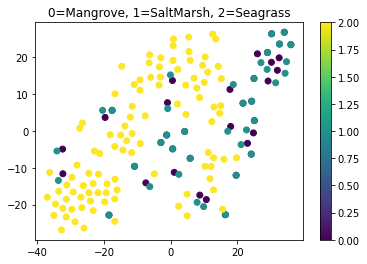

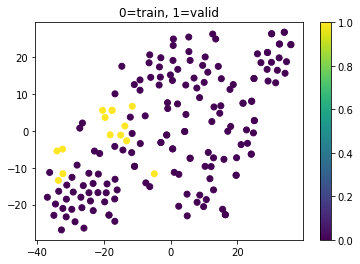

In [53]:
from matplotlib import pyplot as pyplot

scatter = plt.scatter(bigearth_tsneembed[:,0],
            bigearth_tsneembed[:,1],
            c=labels)
plt.title("0=Mangrove, 1=SaltMarsh, 2=Seagrass")
plt.colorbar()
plt.show()

scatter = plt.scatter(bigearth_tsneembed[:,0],
            bigearth_tsneembed[:,1],
            c=[0 for x in range(len_train)]+[1 for x in range(len_valid)])
plt.title("0=train, 1=valid")
plt.colorbar()
plt.show()